# In which I brazenly defy Professor Ng and do his Linear Regression homework in Python instead of Matlab.

This is a "solution" to Andrew Ng's ML course on Coursera for Week 3 programming assignment. It's a solution in the sense that the objectives and ideas in the homework assignment are addressed using Python instead of matlab, and using the actual modules that a data scientist use, rather than implementing the algorithms from scratch. In places I have copied his directions from the homework exactly *in italics*.

>## Tools Covered:
- `SGDClassifier` for general classification problems (like logistic regression) specifying a loss and penalty
- `LogisticRegression` for classification using log-loss and specifying a penalty (regularization)
- `PolynomialFeatures` for automated creation of higher order feature terms


# Logistic Regression
*Suppose that you are the administrator of a university department and
you want to determine each applicant's chance of admission based on their
results on two exams. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, you have the applicant's scores on two exams and the admissions
decision.
Your task is to build a classication model that estimates an applicant's
probability of admission based the scores from those two exams.*


## Plotting the Data

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import snips as snp

In [3]:
cd hw-wk3

C:\Users\Sonya\Box Sync\Projects\course-machine-learning\hw-wk3


In [4]:
df = pd.read_csv("ex2data1.txt", header=None)
df.head()

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


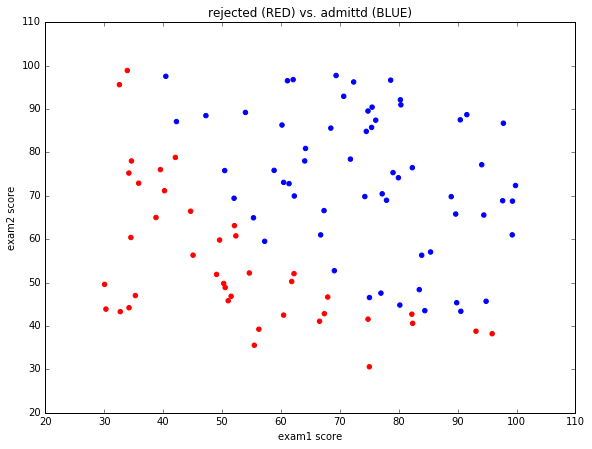

In [87]:
df.columns = ["exam1", "exam2", "admitted"]
fig, ax = snp.newfig()
snp.labs("exam1 score", "exam2 score", "rejected (RED) vs. admittd (BLUE)")
colors = ["r", "b"]
markers = [colors[admits] for admits in df["admitted"]]
ax.scatter(df["exam1"], df["exam2"], color=markers)

## `SGDClassifier` in `sklearn` for Classification Problems
In Week #2 homework we used the sklearn class `SGDRegressor` which does gradient descent for linear regression using a specified loss (and optional penalty). There was a sister class `SGDClassifier` which serves the same purpose but for logistic regression problems. The syntax for using this guy is pretty much identical to what we did with `SGDRegressor` so that's nice! 

Recall though that for logistic regression we don't use a least-squares loss as it is non-convex and doesn't capture the intuition of what we want our penalty to be. Instead a standard loss function, often called "log loss", is used which has the properties:
- when true $y$ is 1, cost increases from 0 to infinity logarithmically as $h$ goes from 1 to 0
- identical but reversed behavior when true $y$ is 0
- thus zero cost when $h(x) = y$ for either 0 or 1 and some moderate cost when $h(x)=0.5$ for either 0 or 1

For binary (label is either 1 or 0) logistic regression this can be captured by:

\begin{align}
\textrm{cost}(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x)),
\end{align}
where again the cost function we seek to minimize is
\begin{align}
J(\theta) = \frac{1}{m}\sum_1^m\frac{1}{2}\textrm{cost}(h_\theta(x_i), y_i).
\end{align}

In [161]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss="log", penalty=None)  # instantiate the classifier object with log loss specified

Recall there were some niceties to be observed in passing data to the fitting objects - for the features it expects a matrix-like object `X`, of the appropriate dimensions, and for the labels it expects a vector-like object `y` with the same number of rows as `X`.

In [177]:
X = df.as_matrix(columns=["exam1", "exam2"])
y = df["admitted"].tolist() # This is the variable we want to predict

*[A quick but important aside: in class when Andrew writes $X$ for the data matrix he usually means this to include a column of all ones for $\theta_0$ (the intercept term). When using all these lovely `sklearn` tools it's not necessary to include this column explicitly in your $X$, it will be created for you.]*

Remember that [a good rule of thumb](http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use) for the number of passes over the training set is `n_iter = np.ceil(10**6 / n)` to get convergence. So let's set that parameter and then try fitting. Remember that calling the `fit` method doesn' return a vector of coefficients, but rather the fit information will be stored as attributes of our object.

In [163]:
classifier.n_iter = np.ceil(10**6 / len(y))
classifier.fit(X, y)
classifier.coef_

array([[ 22.29912697,  22.20844865]])

We probably should have expected similar weights on the two exams, since the data look pretty symmetric around the diagonal `y=x`. Let's see how well the fitted model does on the training set i.e. how many of the training set admissions it correctly predicts. 

## How Well Does the First Order Model Do?
Just as with `SGDRegressor`, predicting new values is simplifed by the `predict` method. But remember that with logistic regression the typical hypothesis form $h_\theta(x)$ returns some value between 0 and 1 which we interpret as the *probability that data point $x$ has corresponding label $y$*. The "prediction" usually then consists of assigning the label based on the whether that probability is greater or less than one half. We can access both these results with `predict` and a new method `predict_proba`.

In [164]:
predict_y = classifier.predict(X=X)
prob_y  = classifier.predict_proba(X=X) 

Let's numerically count the number of samples where the prediction differs from the actual $y$ value, and use that to compute the success percentage of the hypothesis that our classifier landed on.

In [165]:
success = 1-sum(abs(predict_y - y))/len(y)
print("Hypothesis prediction success rate is %.2f" %success)

Hypothesis prediction success rate is 0.89


That's doing pretty well, but we'd like to have a clearer picture of where te model is falling down. We can take a look at all the training data points that were incorrectly predicted by copying them to their own dataframe, and then we can visualize them  on top of the full dataset on our scatterplot. 

In [166]:
errors = df[df["admitted"] != predict_y]
errors

,exam1,exam2,admitted,exam1_sq,exam2_sq,exam12
7,75.024746,46.554014,1,5628.712447,2167.276177,3492.703021
10,95.861555,38.225278,0,9189.437741,1461.171883,3664.334598
16,69.070144,52.740470,1,4770.684801,2781.557147,3642.791842
27,93.114389,38.800670,0,8670.289401,1505.492019,3612.900703
33,52.045405,69.432860,1,2708.724157,4820.922065,3613.661309
36,33.915500,98.869436,0,1150.261148,9775.165324,3353.206359
43,82.368754,40.618255,0,6784.611596,1649.842652,3345.675057
57,32.577200,95.598548,0,1061.273971,9139.082306,3114.333021
79,82.226662,42.719879,0,6761.223874,1824.988022,3512.712995
83,57.238706,59.514282,1,3276.269501,3541.949760,3406.520508


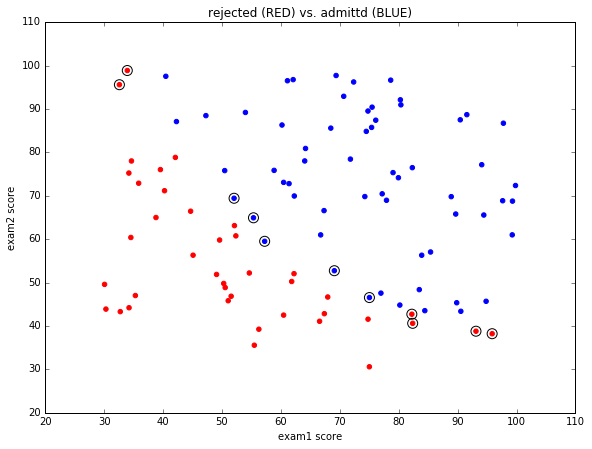

In [167]:
fig, ax = snp.newfig()
snp.labs("exam1 score", "exam2 score", "rejected (RED) vs. admittd (BLUE)")
colors = ["r", "b"]
markers = [colors[admits] for admits in df["admitted"]]
ax.scatter(df["exam1"], df["exam2"], color=markers)

# Now plot black circles around data points that were incorrectly predicted
ax.scatter(errors["exam1"], errors["exam2"], facecolors="none", edgecolors="black", s=100)

## Visualizing the Decision Boundary
Unsurprisingly the hypothesis has trouble with observations that are right on what a human would identify as the sensible decision boundary. We probably don't expect to get any improvement from more iterations, because we know that using the standard sigmoid hypothesis for classification, a data matrix `X` of two features, `exam1` and `exam2` will give a decision boundary that *must* be a straight line in that two-dimensional feature space. From inspecting the scatter plot it doesn't look like there exists a straight line in feature space that completely divides our two labels, so we can't expect any miracles from this algorithm.

We can plot the decision boundary of the fit if we like. Remember, for typical logistic regression our hypothesis takes the sigmoid form:

\begin{align*}
g = \frac{1}{1+\exp(-z_{\theta}(x))},\\
z = \theta^Tx.
\end{align*}

We will predict 1 versus 0 where the hypothesis $g$ is greater than or less than 0.5, respectively. This will occur when the linear model $z$ is greater versus less than 0, respectively. So our decision boundary in feature space is the line $\theta^Tx=0$. The vector of parameters $\theta_T$ is stored as an attribute of the our classifier object:

In [168]:
thetas = np.append(classifier.intercept_, classifier.coef_)
thetas

array([-2728.10501622,    22.29912697,    22.20844865])

This hypothesis then involves computing $z=\theta_0 + \theta_1x_1 + \theta_2x_2$, and the decision boundary of the hypothesis in feature space is where $z=0$. Let's plot this line on top of everything else:

In [169]:
x1 = np.linspace(0,100,100)  # Array of exam1 value
x2 = -thetas[0]/thetas[2] - thetas[1]/thetas[2]*x1  # Corresponding exam2 values along the line z=0

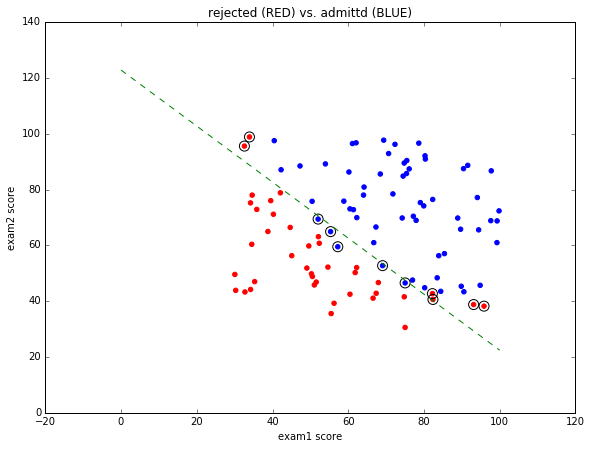

In [170]:
fig, ax = snp.newfig()
snp.labs("exam1 score", "exam2 score", "rejected (RED) vs. admittd (BLUE)")
colors = ["r", "b"]
markers = [colors[admits] for admits in df["admitted"]]
ax.scatter(df["exam1"], df["exam2"], color=markers)

# Now plot black circles around data points that were incorrectly predicted
ax.scatter(errors["exam1"], errors["exam2"], facecolors="none", edgecolors="black", s=100)

# Finally plot the line which represents the decision boundary
ax.plot(x1, x2, color="green", linestyle="--")

## Improving on the First Order Model With Quadratic Terms
By eye I would say permitting some curvature to the decision boundary would do a somewhat better job. To get curved decision boundary in this `exam1`x`exam2` plane we need to add some additional features to the hypothesis that are not linear in the exams scores. To simplify I'll first write a function that does the fitting and then just returns the success rate so then we can test various models more easily. 

In [195]:
def do_fit(classifier, X, y):
    classifier.n_iter = np.ceil(10**6 / len(y))
    classifier.fit(X, y)
    predict_y = classifier.predict(X=X)
    success = 1-sum(abs(predict_y - y))/len(y)
    print("Hypothesis prediction success rate is %.2f" %success)

Let's try it - we'll create two new features which are quadratic in our original exam scores. 

In [196]:
df["exam1_sq"] = df["exam1"]**2  # Define new features
df["exam2_sq"] = df["exam2"]**2

X_quad = df.as_matrix(columns=["exam1", "exam2", "exam1_sq", "exam2_sq"])
do_fit(classifier, X_quad, y)

Hypothesis prediction success rate is 0.83


So it's really not doing any better (actually worse) on the metric of predicting training examples. Just as a reminder though, we know the model will always do better at minimizing the cost function the more complex you make it. This means that even though we seem to have a worse success rate with categorizing the training data, with our new quadratic terms the hypothesis will be miscategorizing these points less "confidently". 

What if we add in the final second order term which is the cross-term $x_1x_2$? In this case it does make some gains:

In [197]:
df["exam12"] = df["exam1"]*df["exam2"]  # Define new feature

X_quad_cross = df.as_matrix(columns=["exam1", "exam2", "exam1_sq", "exam2_sq", "exam12"])
do_fit(classifier, X_quad_cross, y)

Hypothesis prediction success rate is 1.00


## Automate Higher Order Terms with `PolynomialFeatures`
As you might imagine, if you want to build a much higher order model then writing creating each feature individually would be tedious (remember, it's not just the pure terms but all the cross or "interaction" terms as well!). A nice tool for automating this is provided in `sklearn` called [`PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Just like the `StandardScaler` discussed last week, this helper tool has a *transform* method. In this case it takes in your existing features and returns new terms which are higher order transformations of those inputs.

In [218]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)  # Will create features up to two degrees

In [225]:
X[0:4] # A preview of the original two features

array([[ 34.62365962,  78.02469282],
       [ 30.28671077,  43.89499752],
       [ 35.84740877,  72.90219803],
       [ 60.18259939,  86.3085521 ]])

In [226]:
higher_terms = poly.fit_transform(X)
higher_terms[0:4]  # A preview of the new matrix containing original features and their transformations of order 2 or less

array([[  1.00000000e+00,   3.46236596e+01,   7.80246928e+01,
          1.19879781e+03,   2.70150041e+03,   6.08785269e+03],
       [  1.00000000e+00,   3.02867108e+01,   4.38949975e+01,
          9.17284849e+02,   1.32943509e+03,   1.92677081e+03],
       [  1.00000000e+00,   3.58474088e+01,   7.29021980e+01,
          1.28503672e+03,   2.61335489e+03,   5.31473048e+03],
       [  1.00000000e+00,   6.01825994e+01,   8.63085521e+01,
          3.62194527e+03,   5.19427301e+03,   7.44916616e+03]])

## Alternative `sklearn` Tool `LogisticRegression`
Just like in linear regression last week, there is a more specific class in `sklearn` that you can use for basic logistic regression. In contrast to `SGDClassifier`, with this tool the loss is fixed as "log-loss" but you get to specify the "solver" i.e. the algorithm used to do the fitting. Stochastic Gradient Descent is one option for the solver (`sag`), but the default solver `liblinear` actually uses something called [coordinate descent](https://en.wikipedia.org/wiki/Coordinate_descent) which is an algorithm that doesn't involve computing the derivative of the cost function, only it's values. The documentation has a neat little [table for choosing the right solver](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) for your problem.

In [239]:
from sklearn.linear_model import LogisticRegression
logregressor = LogisticRegression(solver="liblinear")

This class handles multiclass classification (more than two labels) and offers you the *one-versus-rest* approach that Andrew discussed in class, as well as a different method called *multinomial*. Since this homework set doesn't address multiclass we'll leave it at that for now.

Bizarrely, the use of the `LogisticRegression` class without a "penalty" is not permitted so let's refresh exactly what is meant by penalty and why we use it.

# Regularized Logistic Regression
As Andrew discussed, if you continue adding features left and right to obtain better and better fits to the training data (as you are guaranteed to do) you are likely *overfitting* and your model won't capture the underlying relationships in the system and thus won't generalize well to new data points. A very useful way to combat this is to allow your form of hypothesis to be complex, but to fit that hypothesis using regularized regression. **With regularization, the loss function includes a penalty term which dampens the effect of the features by preferring small parameter values in the fit.** Formally the cost function looks like

\begin{align}
J_{LSQ}^{reg}(\theta) = \frac{1}{m}\bigg[\sum_1^m\frac{1}{2}(h(x_i)-y_i)^2 + \lambda\sum_1^n\theta_j^2\bigg].
\end{align}

The two terms in the expression capture two goals - to fit the training set well, and to find a simple, smooth relationship that will generalize to new data well. But note if your $\lambda$ is too large you will wind up underfitting ($h_\theta(x) \approx \theta_0$). The nature of how you penalize the "largeness" of your $\theta$ values actually matters a decent bit - the two common penalties are $L1$ and $L2$, and [this quora response](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization/answer/Justin-Solomon) gives a breathtakingly clear explanation of the difference. 

**The default penalty for `sklearn`s `LogisticRegression` is $L2$**, so let's take a look at how this guy does on the same problem, now that we know *what* it does.

In [240]:
def do_fit_logreg(classifier, X, y):
    classifier.fit(X, y)
    predict_y = classifier.predict(X=X)
    success = 1-sum(abs(predict_y - y))/len(y)
    print("Hypothesis prediction success rate is %.2f" %success)

In [241]:
do_fit_logreg(logregressor, X, y)  # Remember, X is the simple two-feature model

Hypothesis prediction success rate is 0.87


This fitted hypothesis is also doing a similarly decent job with just the two features, let's try it on the full model:

In [242]:
do_fit_logreg(logregressor, X_quad_cross, y)

Hypothesis prediction success rate is 1.00


In [243]:
thetas = np.append(logregressor.intercept_, logregressor.coef_)
thetas

array([ -2.04642679e-02,  -5.62331307e-01,  -6.46537215e-01,
         5.10961767e-04,   1.33146067e-03,   1.91678695e-02])

Unsurprisingly perhaps we get a very similar result as with `SGDClassifier`. This confirms that our penalty was not overly aggressive - we haven't prevented the algorithm from fitting a nice curve in our space `exam1`x`exam2`. **We can vary the regularization penalty with the attribute `C` which is the inverse of the regularization strength.** Let's see if we can force an underfitting:

In [244]:
print(logregressor.C)  # The default value
logregressor.C = 0.0001
do_fit_logreg(logregressor, X_quad_cross, y)

1.0
Hypothesis prediction success rate is 0.78


In [245]:
thetas = np.append(logregressor.intercept_, logregressor.coef_)
thetas

array([-0.00074503, -0.02135915, -0.02275659, -0.00047263, -0.0005028 ,
        0.0019689 ])

Notice how much smaller these fitted values in $\theta$ are compared to the values we got with the unpenalized `SGDClassifier` and the reasonable penalty `LogisticRegression` runs. That is exactly what regularization is designed to do, we've just taken it too far in this case.

# Summary
Logistic Regression to fit the typical sigmoid hypothesis form can be done with `SGDClassifier` wherein you specify the specific loss function and penalty, and it will always use stochastic gradient descent for the optimization. The class `LogisticRegression` is less general and always uses the common log-loss, but still allows you do regularization using either $L1$ or $L2$ penalty. With this tool you must specify the "solver" it uses to actually do the optimization and a coordinate descent method is the default. In all cases the tool `PolynomialFeatures` automates the construction of higher order terms for you, just be sure to regularize properly in order to avoid overfitting. 